
Training LeNet...
Epoch 1/2


c:\Users\Arun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5785 - loss: 0.6734 - val_accuracy: 0.7854 - val_loss: 0.4881
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7258 - loss: 0.5538 - val_accuracy: 0.8195 - val_loss: 0.4251

LeNet Test Accuracy: 0.8195


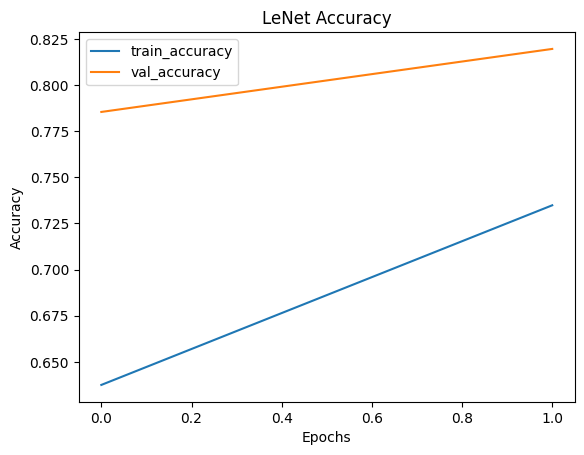


Training AlexNet...
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 726ms/step - accuracy: 0.4787 - loss: 1.9324 - val_accuracy: 0.4341 - val_loss: 0.6992
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 701ms/step - accuracy: 0.5377 - loss: 0.6912 - val_accuracy: 0.4341 - val_loss: 0.7063

AlexNet Test Accuracy: 0.4341


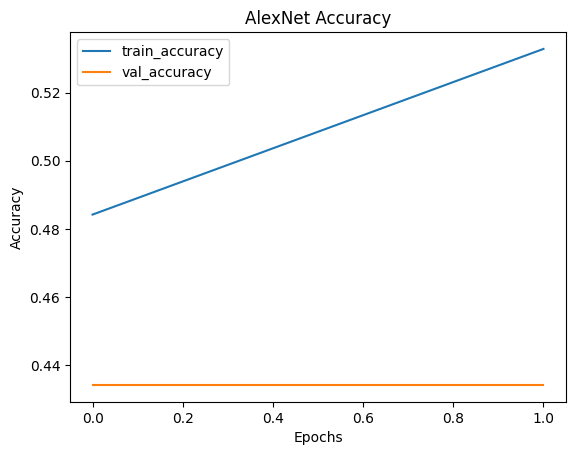


Training VGG16...
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 315s 12s/step - accuracy: 0.4889 - loss: 0.8227 - val_accuracy: 0.5659 - val_loss: 0.6929
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step - accuracy: 0.5196 - loss: 0.6930 - val_accuracy: 0.4341 - val_loss: 0.7015

VGG16 Test Accuracy: 0.4341


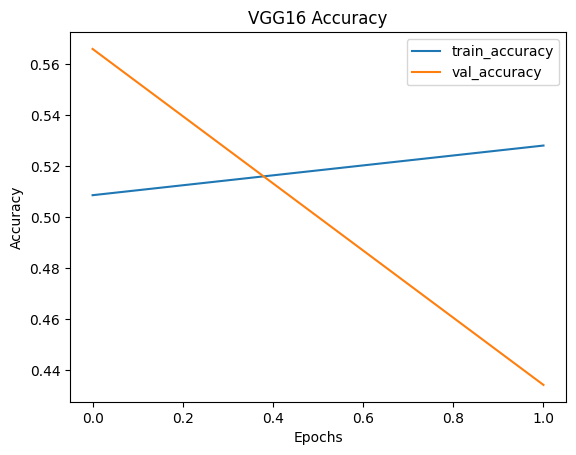


Training ResNet50...
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.5658 - loss: 20.5500 - val_accuracy: 0.4098 - val_loss: 643.9809
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5985 - loss: 5.2180 - val_accuracy: 0.4341 - val_loss: 32151.1465

ResNet50 Test Accuracy: 0.4341


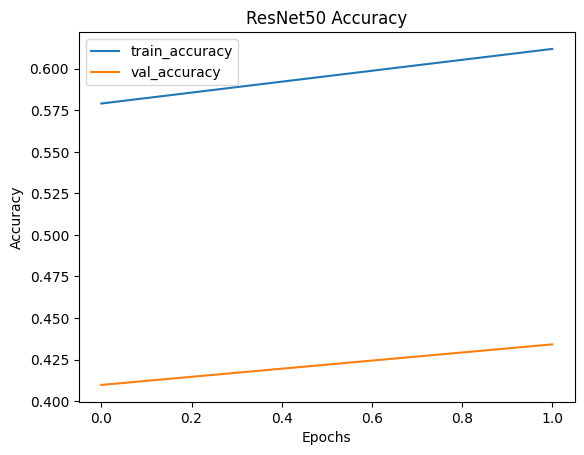


Training MobileNet...
Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 979ms/step - accuracy: 0.5373 - loss: 8.1977 - val_accuracy: 0.5659 - val_loss: 0.6875
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.8682 - loss: 0.5453 - val_accuracy: 0.5659 - val_loss: 0.7237

MobileNet Test Accuracy: 0.5659


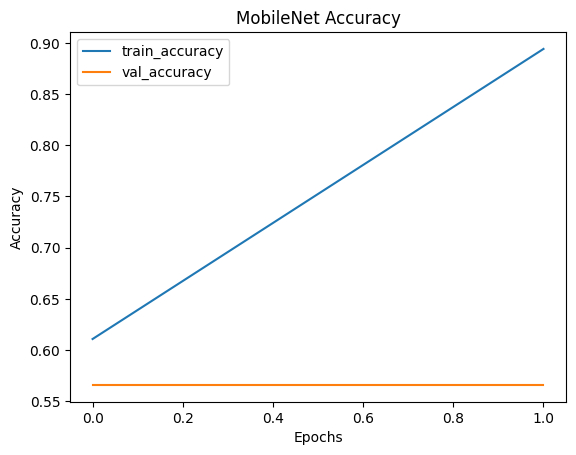

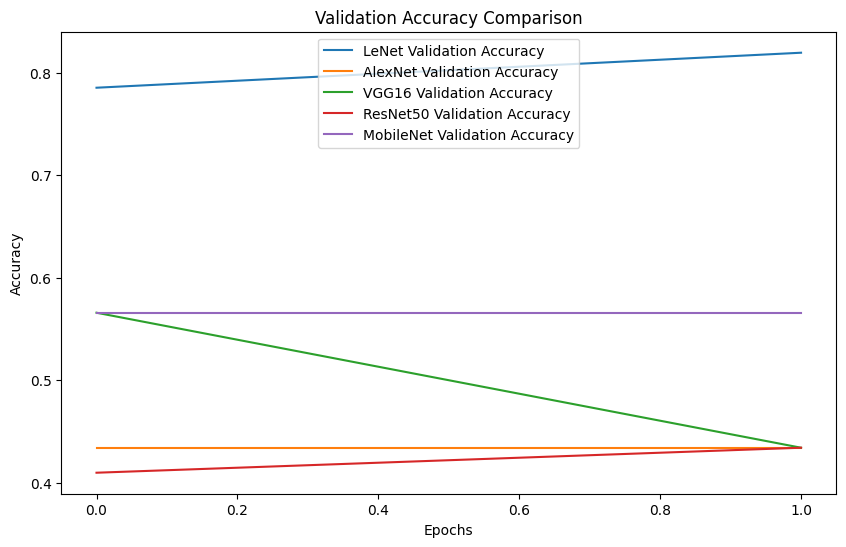

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load Horses or Humans dataset from TFDS
(ds_train, ds_test), ds_info = tfds.load('horses_or_humans', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

# Preprocessing function to normalize and resize images
def preprocess(image, label, target_size):
    image = tf.image.resize(image, target_size) / 255.0  # Normalize to [0, 1]
    label = tf.one_hot(label, depth=2)  # Convert label to one-hot encoding
    return image, label

# Preprocessing for LeNet (28x28 grayscale)
def preprocess_lenet(image, label):
    image = tf.image.resize(image, (28, 28)) / 255.0
    image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    label = tf.one_hot(label, depth=2)
    return image, label

# Prepare datasets for different models
train_ds_vgg = ds_train.map(lambda img, lbl: preprocess(img, lbl, (224, 224))).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_vgg = ds_test.map(lambda img, lbl: preprocess(img, lbl, (224, 224))).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds_lenet = ds_train.map(preprocess_lenet).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_lenet = ds_test.map(preprocess_lenet).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds_alexnet = ds_train.map(lambda img, lbl: preprocess(img, lbl, (227, 227))).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds_alexnet = ds_test.map(lambda img, lbl: preprocess(img, lbl, (227, 227))).batch(32).prefetch(tf.data.AUTOTUNE)

# --- Define LeNet ---
def build_lenet():
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1)),
        AveragePooling2D(pool_size=(2, 2)),
        Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(2, activation='softmax')  # Binary classification
    ])
    return model

# --- Define AlexNet ---
def build_alexnet():
    model = Sequential([
        Conv2D(96, kernel_size=(11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

# --- Function to build pretrained models (VGG16, ResNet50, MobileNet) ---
def build_pretrained_model(base_model, num_classes):
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# --- Compile and Train Models ---
def compile_and_train(model, model_name, train_data, val_data, epochs=2):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=epochs, verbose=1)
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(val_data, verbose=0)
    print(f"\n{model_name} Test Accuracy: {test_acc:.4f}")
    
    # Plot training history
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return history

# Collect histories for all models
histories = {}

# --- Train LeNet ---
lenet_model = build_lenet()
print("\nTraining LeNet...")
histories['LeNet'] = compile_and_train(lenet_model, "LeNet", train_ds_lenet, val_ds_lenet, epochs=2)

# --- Train AlexNet ---
alexnet_model = build_alexnet()
print("\nTraining AlexNet...")
histories['AlexNet'] = compile_and_train(alexnet_model, "AlexNet", train_ds_alexnet, val_ds_alexnet, epochs=2)

# --- Train VGG16 ---
vgg16_base = VGG16(input_shape=(224, 224, 3), include_top=False, weights=None)
vgg16_model = build_pretrained_model(vgg16_base, 2)
print("\nTraining VGG16...")
histories['VGG16'] = compile_and_train(vgg16_model, "VGG16", train_ds_vgg, val_ds_vgg, epochs=2)

# --- Train ResNet50 ---
resnet50_base = ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)
resnet50_model = build_pretrained_model(resnet50_base, 2)
print("\nTraining ResNet50...")
histories['ResNet50'] = compile_and_train(resnet50_model, "ResNet50", train_ds_vgg, val_ds_vgg, epochs=2)

# --- Train MobileNet ---
mobilenet_base = MobileNet(input_shape=(224, 224, 3), include_top=False, weights=None)
mobilenet_model = build_pretrained_model(mobilenet_base, 2)
print("\nTraining MobileNet...")
histories['MobileNet'] = compile_and_train(mobilenet_model, "MobileNet", train_ds_vgg, val_ds_vgg, epochs=2)

# Plot accuracy graph for all models
plt.figure(figsize=(10, 6))
for model_name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()